In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
)

from xgboost import XGBClassifier

uploaded = files.upload()
fname = list(uploaded.keys())[0]

Saving yelp_labelled.txt to yelp_labelled.txt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded[fname]), sep='\t', header=None, names=['text', 'target'])
print(df.shape)
display(df.head())

print("\nPercentual:")
print(df['target'].value_counts(normalize=True)*100)

(1000, 2)


,text,target
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1



Percentual:
target
1    50.0
0    50.0
Name: proportion, dtype: float64


In [ ]:
df.shape

(1000, 2)

In [ ]:
df = df.iloc[1:].copy()

df['target'] = pd.to_numeric(df['target'])

X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Tamanhos -> treino: {X_train.shape[0]} | teste: {X_test.shape[0]}")

Tamanhos -> treino: 749 | teste: 250


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("Dimensão TF-IDF (treino):", X_train_tfidf.shape)

Dimensão TF-IDF (treino): (749, 1434)


In [ ]:
lr_model = LogisticRegression(
    C=2,
    penalty='elasticnet',
    solver='saga',
    l1_ratio=0.3,
    max_iter=3000,
    random_state=42,
    n_jobs=-1
)

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

In [ ]:
lr_model.fit(X_train_tfidf, y_train)
xgb_model.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:11:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [ ]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

y_pred_xgb = xgb_model.predict(X_test_tfidf)
y_proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

In [ ]:
def avaliar_modelo(nome, y_true, y_pred, y_proba):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    print(f"== {nome} ==")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"AUC-PR (AP): {ap:.4f}\n")

avaliar_modelo("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
avaliar_modelo("XGBoost", y_test, y_pred_xgb, y_proba_xgb)

== Logistic Regression ==
Acurácia: 0.8240
Precisão: 0.8347
Recall: 0.8080
F1: 0.8211
AUC-ROC: 0.9057
AUC-PR (AP): 0.9218

== XGBoost ==
Acurácia: 0.7520
Precisão: 0.7480
Recall: 0.7600
F1: 0.7540
AUC-ROC: 0.8192
AUC-PR (AP): 0.8368



In [ ]:
positive_class_index = 1

probs_lr = lr_model.predict_proba(X_test_tfidf)
probs_xgb = xgb_model.predict_proba(X_test_tfidf)

positive_probs_lr = probs_lr[:,1]
positive_probs_xgb = probs_xgb[:,1]

In [ ]:
print(probs_lr)

[[0.86211969 0.13788031]
 [0.64947028 0.35052972]
 [0.58947827 0.41052173]
 [0.58160307 0.41839693]
 [0.63885373 0.36114627]
 [0.61618101 0.38381899]
 [0.65874525 0.34125475]
 [0.61823533 0.38176467]
 [0.18894222 0.81105778]
 [0.35349316 0.64650684]
 [0.52486094 0.47513906]
 [0.23481925 0.76518075]
 [0.77861612 0.22138388]
 [0.59713325 0.40286675]
 [0.11179509 0.88820491]
 [0.60656332 0.39343668]
 [0.58294637 0.41705363]
 [0.27689526 0.72310474]
 [0.44782859 0.55217141]
 [0.62460474 0.37539526]
 [0.38332873 0.61667127]
 [0.37517951 0.62482049]
 [0.07341721 0.92658279]
 [0.71118686 0.28881314]
 [0.7756317  0.2243683 ]
 [0.24746486 0.75253514]
 [0.63637751 0.36362249]
 [0.32217338 0.67782662]
 [0.49789609 0.50210391]
 [0.32808594 0.67191406]
 [0.42747518 0.57252482]
 [0.56941605 0.43058395]
 [0.24388878 0.75611122]
 [0.62128754 0.37871246]
 [0.76825803 0.23174197]
 [0.07786685 0.92213315]
 [0.42424454 0.57575546]
 [0.72576201 0.27423799]
 [0.24035773 0.75964227]
 [0.24649364 0.75350636]


In [ ]:
print(probs_xgb)

[[9.7054994e-01 2.9450050e-02]
 [5.5626976e-01 4.4373026e-01]
 [2.9416907e-01 7.0583093e-01]
 [8.7183952e-02 9.1281605e-01]
 [8.6389250e-01 1.3610749e-01]
 [8.9593989e-01 1.0406009e-01]
 [7.8634429e-01 2.1365574e-01]
 [6.8741107e-01 3.1258893e-01]
 [1.4452457e-02 9.8554754e-01]
 [2.1867007e-01 7.8132993e-01]
 [6.7434430e-01 3.2565573e-01]
 [1.4919215e-01 8.5080785e-01]
 [9.5269889e-01 4.7301095e-02]
 [1.6926652e-01 8.3073348e-01]
 [6.7347288e-03 9.9326527e-01]
 [5.1431125e-01 4.8568875e-01]
 [7.9980713e-01 2.0019287e-01]
 [1.2261313e-01 8.7738687e-01]
 [6.7460871e-01 3.2539126e-01]
 [5.7980740e-01 4.2019260e-01]
 [4.1346949e-01 5.8653051e-01]
 [1.2229431e-01 8.7770569e-01]
 [3.8933456e-02 9.6106654e-01]
 [9.1175431e-01 8.8245675e-02]
 [6.5139002e-01 3.4860998e-01]
 [3.8966596e-02 9.6103340e-01]
 [6.3694012e-01 3.6305988e-01]
 [4.0506572e-01 5.9493428e-01]
 [3.5272878e-01 6.4727122e-01]
 [7.6435626e-02 9.2356437e-01]
 [6.6731870e-02 9.3326813e-01]
 [6.8463910e-01 3.1536093e-01]
 [7.9014

In [ ]:
df_pos_lr = pd.DataFrame({"prob_spam": positive_probs_lr,"target":y_test})
df_pos_xgb = pd.DataFrame({"prob_spam": positive_probs_xgb,"target":y_test})

In [ ]:
df_pos_lr

,prob_spam,target
463,0.137880,0
428,0.350530,0
235,0.410522,0
374,0.418397,0
28,0.361146,0
...,...,...
346,0.384405,1
203,0.935532,1
711,0.137936,0
99,0.797379,1


In [ ]:
df_pos_xgb

,prob_spam,target
463,0.029450,0
428,0.443730,0
235,0.705831,0
374,0.912816,0
28,0.136107,0
...,...,...
346,0.216230,1
203,0.961067,1
711,0.007622,0
99,0.983562,1


In [ ]:
df_apenas_positivo_lr = df_pos_lr.loc[df_pos_lr['target']==1]
df_apenas_positivo_xgb = df_pos_xgb.loc[df_pos_xgb['target']==1]

In [ ]:
df_apenas_positivo_lr

,prob_spam,target
184,0.341255,1
896,0.811058,1
674,0.765181,1
134,0.888205,1
404,0.417054,1
...,...,...
725,0.890840,1
346,0.384405,1
203,0.935532,1
99,0.797379,1


In [ ]:
df_apenas_positivo_xgb

,prob_spam,target
184,0.213656,1
896,0.985548,1
674,0.850808,1
134,0.993265,1
404,0.200193,1
...,...,...
725,0.988743,1
346,0.216230,1
203,0.961067,1
99,0.983562,1


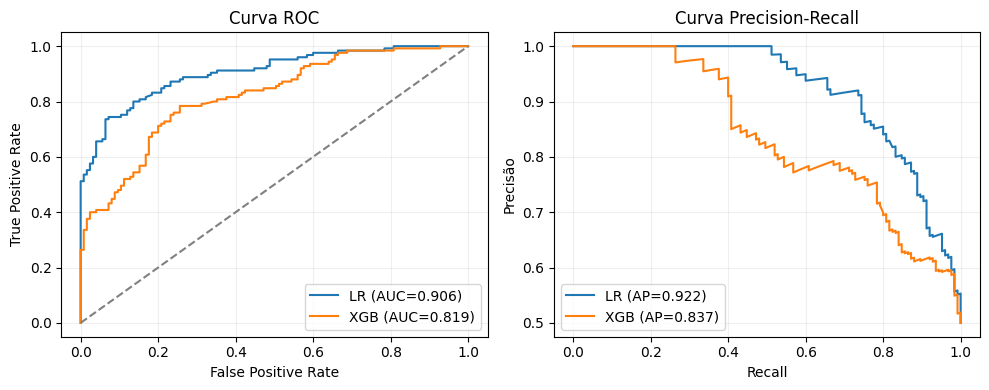

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_score(y_test, y_proba_lr):.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB (AUC={roc_auc_score(y_test, y_proba_xgb):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(alpha=0.2)

plt.subplot(1,2,2)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_proba_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
plt.plot(rec_lr, prec_lr, label=f"LR (AP={average_precision_score(y_test, y_proba_lr):.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGB (AP={average_precision_score(y_test, y_proba_xgb):.3f})")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(alpha=0.2)

plt.tight_layout()
plt.show()

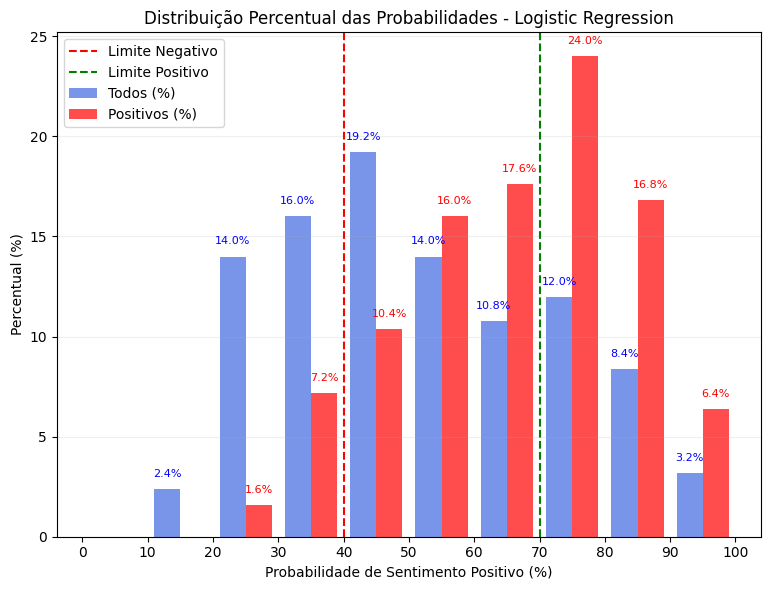

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

step = 0.1
bins = np.arange(0, 1 + step, step)
threshold_neg = 0.4
threshold_pos = 0.7

def plot_distribuicao(y_true, y_pred_proba, nome_modelo):
    """
    Cria o gráfico de distribuição percentual das probabilidades
    mostrando TODAS as previsões vs. amostras realmente positivas.
    """
    hist_all, _ = np.histogram(y_pred_proba, bins=bins)
    hist_pos, _ = np.histogram(y_pred_proba[y_true == 1], bins=bins)

    hist_all_pct = (hist_all / hist_all.sum()) * 100
    hist_pos_pct = (hist_pos / hist_pos.sum()) * 100

    x = (bins[:-1] + bins[1:]) / 2
    width = step * 0.4

    plt.bar(x - width/2, hist_all_pct, width=width, label='Todos (%)', alpha=0.7, color='royalblue')
    plt.bar(x + width/2, hist_pos_pct, width=width, label='Positivos (%)', alpha=0.7, color='red')

    for xi, val in zip(x - width/2, hist_all_pct):
        if val > 0:
            plt.text(xi, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=8, color='blue')
    for xi, val in zip(x + width/2, hist_pos_pct):
        if val > 0:
            plt.text(xi, val + 0.5, f"{val:.1f}%", ha='center', va='bottom', fontsize=8, color='red')

    plt.axvline(threshold_neg, color='red', linestyle='--', label='Limite Negativo')
    plt.axvline(threshold_pos, color='green', linestyle='--', label='Limite Positivo')

    plt.xlabel('Probabilidade de Sentimento Positivo (%)')
    plt.ylabel('Percentual (%)')
    plt.title(f'Distribuição Percentual das Probabilidades - {nome_modelo}')
    plt.xticks(np.arange(0, 1.1, 0.1), [f'{int(v*100)}' for v in np.arange(0, 1.1, 0.1)])
    plt.legend()
    plt.grid(axis='y', alpha=0.2)


plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plot_distribuicao(y_test, y_proba_lr, "Logistic Regression")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

def avaliar_com_threshold(nome, y_true, y_proba, threshold=0.5):
    """
    Avalia o modelo usando um ponto de corte (threshold) customizado.
    """
    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    aucroc = roc_auc_score(y_true, y_proba)
    aucpr = average_precision_score(y_true, y_proba)

    print(f"\n== {nome} com threshold = {threshold} ==")
    print(f"Acurácia: {acc:.4f}")
    print(f"Precisão: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC-ROC: {aucroc:.4f}")
    print(f"AUC-PR (AP): {aucpr:.4f}")

    return {
        'threshold': threshold,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'aucroc': aucroc,
        'aucpr': aucpr
    }

In [ ]:
for th in [0.4, 0.7]:
    avaliar_com_threshold("Logistic Regression", y_test, y_proba_lr, threshold=th)


== Logistic Regression com threshold = 0.4 ==
Acurácia: 0.7360
Precisão: 0.6746
Recall: 0.9120
F1: 0.7755
AUC-ROC: 0.9057
AUC-PR (AP): 0.9218

== Logistic Regression com threshold = 0.7 ==
Acurácia: 0.7360
Precisão: 1.0000
Recall: 0.4720
F1: 0.6413
AUC-ROC: 0.9057
AUC-PR (AP): 0.9218


# Relatório de Avaliação de Modelos de Classificação de Sentimentos (Yelp Reviews)

## 1. Modelos Treinados
- Logistic Regression  
- XGBoost  

___

## 2. Métricas Obtidas

| Modelo | Acurácia | Precisão | Recall | F1 | AUC-ROC | AUC-PR |
|:--|:--:|:--:|:--:|:--:|:--:|:--:|
| Logistic Regression (threshold = 0.5) | **0.820** | **0.844** | 0.784 | **0.813** | **0.880** | **0.904** |
| XGBoost | 0.724 | 0.725 | 0.720 | 0.722 | 0.799 | 0.829 |

___

## 3. Análise dos Resultados

- A **Regressão Logística** apresentou **melhor equilíbrio entre precisão e recall**, além de **maior F1-Score**, indicando melhor desempenho geral.  
- O **AUC-ROC (0.880)** e o **AUC-PR (0.904)** confirmam que o modelo tem excelente capacidade de separação e calibração das probabilidades.  
- O **XGBoost**, embora forte, apresentou **probabilidades menos calibradas** e distribuição mais dispersa, o que pode afetar a interpretação dos resultados.

___

## 4. Conclusão

O modelo **Logistic Regression** é o **mais adequado** para esta base de sentimentos balanceada.  
Ele oferece:
- Maior **precisão e estabilidade**;
- **Melhor calibração** das probabilidades;
- **Maior interpretabilidade** e robustez, mesmo com ajustes de limiar.

✅ **Modelo Recomendado:** Logistic Regression